In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer


# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.simplefilter("ignore", DeprecationWarning)


In [2]:
papers = pd.read_csv("papers.csv")
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


## Exploring the Data

In [3]:
#statistical summary of the paper
papers.describe(include='all')

,id,year,title,event_type,pdf_name,abstract,paper_text
count,7241.000000,7241.000000,7241,2422,7241,7241,7241
unique,NaN,NaN,7241,3,7241,3923,7237
top,NaN,NaN,A Reconfigurable Analog VLSI Neural Network Chip,Poster,6933-process-constrained-batch-bayesian-optimi...,Abstract Missing,Dynamics of Supervised Learning with\nRestrict...
freq,NaN,NaN,1,2146,1,3317,2
mean,3655.912167,2006.439718,NaN,NaN,NaN,NaN,NaN
std,2098.435219,8.759919,NaN,NaN,NaN,NaN,NaN
min,1.000000,1987.000000,NaN,NaN,NaN,NaN,NaN
25%,1849.000000,2000.000000,NaN,NaN,NaN,NaN,NaN
50%,3659.000000,2009.000000,NaN,NaN,NaN,NaN,NaN
75%,5473.000000,2014.000000,NaN,NaN,NaN,NaN,NaN


In [4]:
## remove extraneous columns for analysis
papers.drop(columns=['id', 'event_type', 'pdf_name'], inplace=True)

Text(0.5, 1.0, 'Machine Learning Publications since 1987')

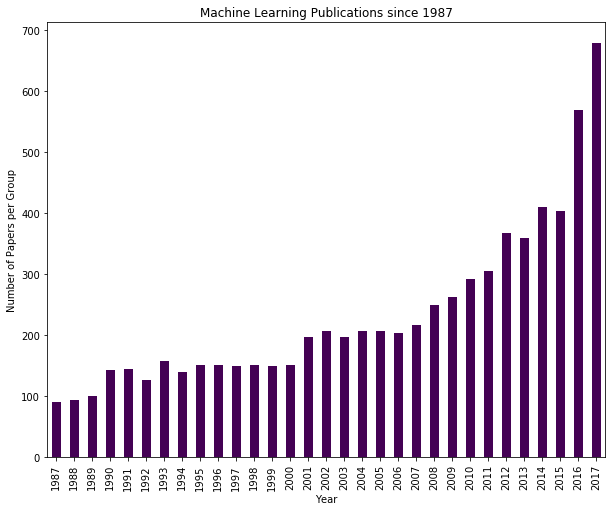

In [5]:
groups = papers.groupby('year')
counts = groups.size()

plt.figure(figsize= (10,8))
counts.plot(kind='bar', colormap='viridis')
# sns.countplot(x='year', data=papers, palette='viridis')
plt.xlabel('Year')
plt.ylabel('Number of Papers per Group')
plt.title('Machine Learning Publications since 1987')

## Data Preprocessing

In [6]:
def pre_processing(data, col):
    """
    uses regular expressions to remove punctuations in titles 
    re.sub('[,\.!?]', '', x))
    """
    # Remove punctuation
    data['title_processed'] = data[col].map(lambda x: re.sub('[,\.!?]', '', x))

    # convert words to lower case
    data['title_processed'] = data['title_processed'].map(lambda x: x.lower())
    

In [7]:
pre_processing(papers, 'title')

In [8]:
papers.title.sample(3)

5575    Learning shape correspondence with anisotropic...
5653    Linear-Memory and Decomposition-Invariant Line...
741     Information Factorization in Connectionist Mod...
Name: title, dtype: object

In [9]:
def create_wc(data, col):
    """ Create a wordcloud to visualizae titles"""
    long_string = " ".join(data[col])
    wc = WordCloud()
    wc.generate(long_string)
#     wc.to_image()
    return wc.to_image()

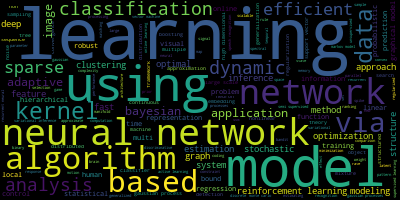

In [10]:
create_wc(papers, 'title_processed')

## Topic Modeling

In [11]:
def most_common_words(count_data, count_vectorizer):
    '''plot most common '''
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    plt.bar(x_pos, counts,align='center', color = 'grey')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()
    

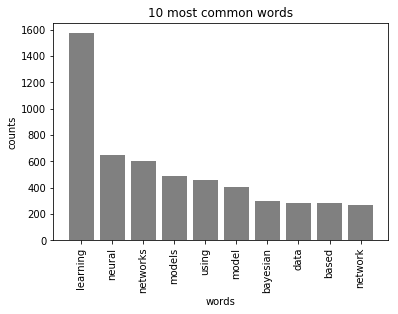

In [12]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(papers['title_processed'])
most_common_words(count_data, count_vectorizer)

## Tokenize Sentences

In [13]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [14]:
data = papers.title_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['self', 'organization', 'of', 'associative', 'database', 'and', 'its', 'applications']]


## Build the Bigram, Trigram Models and Lemmatize

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [16]:
# processed Text Data!
data_ready = process_words(data_words)

## Build the Topic Model

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.027*"reinforcement" + 0.026*"base" + 0.023*"information" + 0.022*"system" '
  '+ 0.022*"function" + 0.020*"linear" + 0.019*"classification" + '
  '0.018*"problem" + 0.018*"mixture" + 0.017*"net"'),
 (1,
  '0.077*"model" + 0.077*"learning" + 0.020*"representation" + '
  '0.019*"application" + 0.018*"training" + 0.017*"image" + 0.016*"state" + '
  '0.015*"efficient" + 0.015*"computational" + 0.013*"continuous"'),
 (2,
  '0.142*"network" + 0.084*"neural" + 0.028*"dynamic" + 0.027*"correlation" + '
  '0.017*"deep" + 0.017*"recognition" + 0.013*"recurrent" + 0.013*"adaptive" + '
  '0.012*"prediction" + 0.011*"optimization"'),
 (3,
  '0.098*"learn" + 0.040*"analysis" + 0.027*"interpolation" + '
  '0.027*"synthesis" + 0.023*"algorithm" + 0.021*"datum" + 0.019*"stochastic" '
  '+ 0.018*"cluster" + 0.018*"structure" + 0.016*"non"')]


##  Dominant topic and its percentage contribution in each document

In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5113,"model, learning, representation, application, ...","[associative, database, application]"
1,1,2.0,0.6837,"network, neural, dynamic, correlation, deep, r...","[theory, layer, visual, cortex, application, a..."
2,2,3.0,0.3438,"learn, analysis, interpolation, synthesis, alg...","[store, covariance, associative, long, term, p..."
3,3,2.0,0.4501,"network, neural, dynamic, correlation, deep, r...","[bayesian, neural, network, model]"
4,4,2.0,0.4500,"network, neural, dynamic, correlation, deep, r...","[neural, network, active, learning]"
5,5,0.0,0.3241,"reinforcement, base, information, system, func...","[neural, net, deformable, model]"
6,6,1.0,0.6008,"model, learning, representation, application, ...","[plasticity, mediate, competitive, learning]"
7,7,0.0,0.6250,"reinforcement, base, information, system, func...",[classification]
8,8,2.0,0.8020,"network, neural, dynamic, correlation, deep, r...","[plasma, neural, network]"
9,9,3.0,0.8580,"learn, analysis, interpolation, synthesis, alg...","[synapse, non, volatile, analogue, amorphous]"


## The most representative sentence for each topic

In [19]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9107,"reinforcement, base, information, system, function, linear, classification, problem, mixture, net","[dynamical, synapsis, give, rise, power_law, distribution, neuronal, avalanche]"
1,1.0,0.9166,"model, learning, representation, application, training, image, state, efficient, computational, ...","[online, bayesian, moment, topic, model, unknown, number, topic]"
2,2.0,0.9166,"network, neural, dynamic, correlation, deep, recognition, recurrent, adaptive, prediction, optim...","[safetynet, verifiable, execution, deep, neural, network, untrusted, cloud]"
3,3.0,0.9166,"learn, analysis, interpolation, synthesis, algorithm, datum, stochastic, cluster, structure, non","[fast, non, ergodic, stochastic, alternate, direction, method, multiplier]"


## Frequency Distribution of Word Counts in Documents

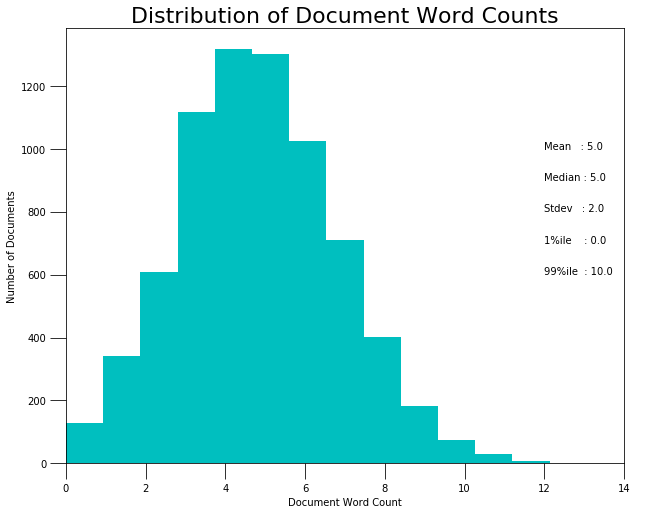

In [20]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,8))
plt.hist(doc_lens, bins = 15, color='c')
plt.text(12, 1000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(12, 900, "Median : " + str(round(np.median(doc_lens))))
plt.text(12, 800, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(12,  700, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(12,  600, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 14), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
# plt.xticks(np.linspace(0,15,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

## Word Count of Topic Keywords

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


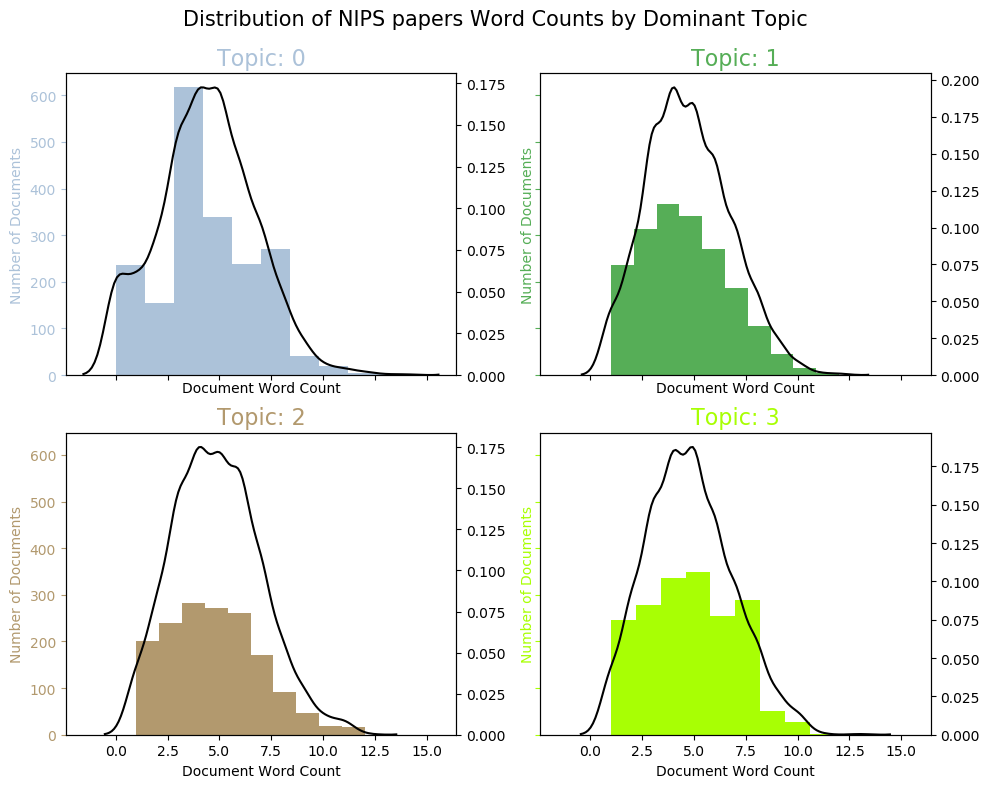

In [21]:
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,8), dpi=100, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 10, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of NIPS papers Word Counts by Dominant Topic', fontsize=15)
plt.show()

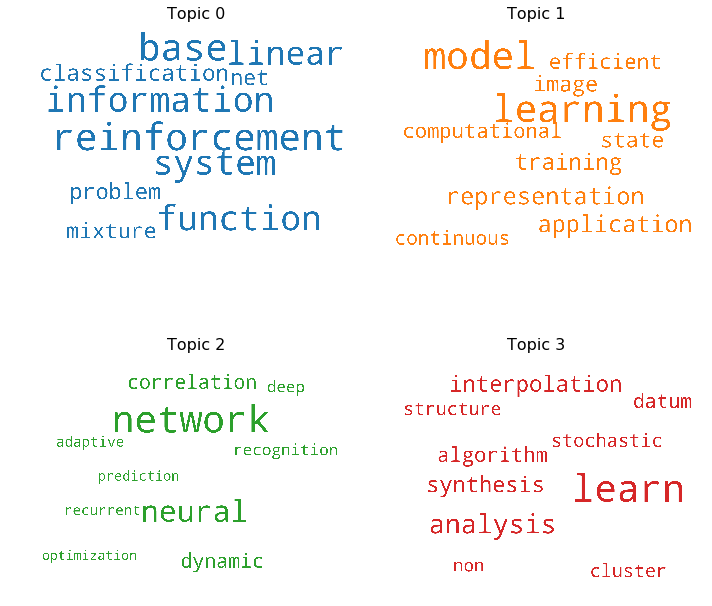

In [22]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

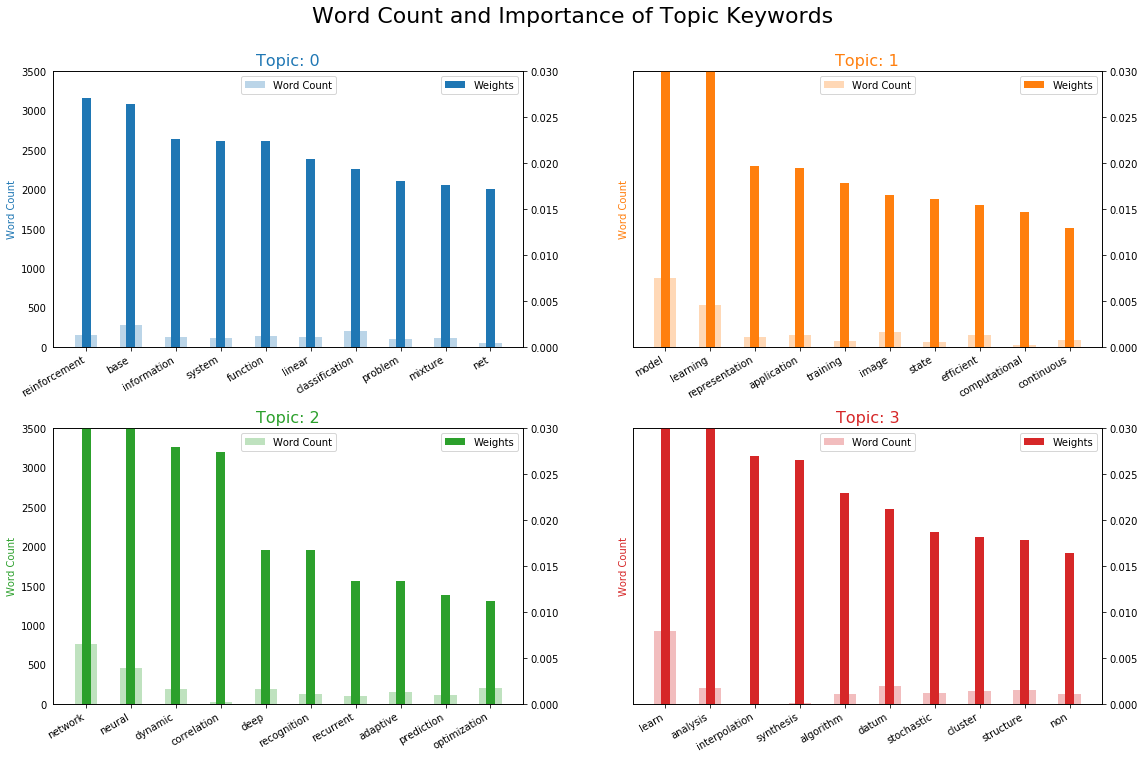

In [23]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc=9); ax_twin.legend(loc='best')

fig.tight_layout(w_pad=6)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Most discussed topics in the NIPS papers?

In [24]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

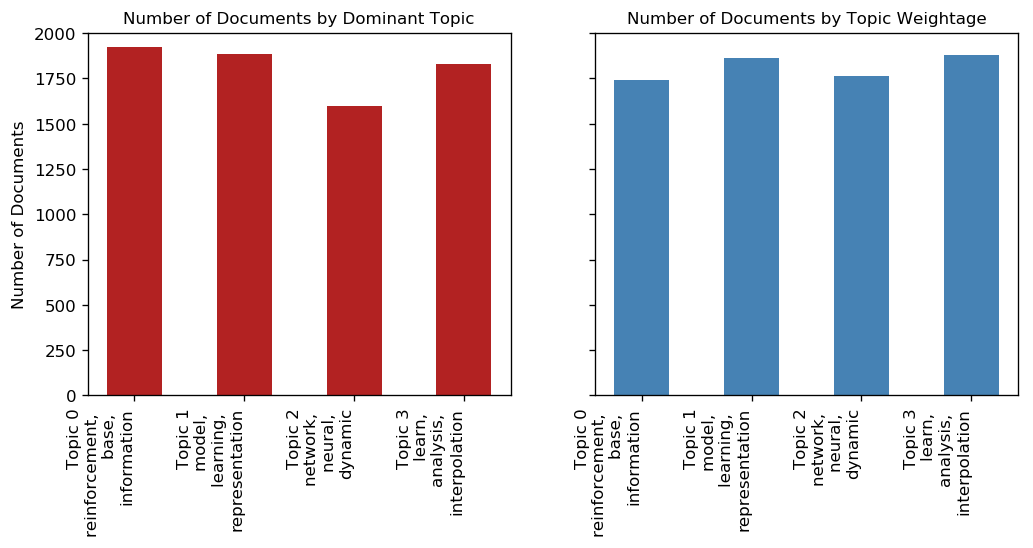

In [25]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
ax1.set_xticklabels(df_dominant_topic_in_each_doc['Dominant_Topic'], rotation=90, horizontalalignment= 'right')
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.set_xticklabels(df_dominant_topic_in_each_doc['Dominant_Topic'], rotation=90, horizontalalignment= 'right')
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

##  t-SNE Clustering Chart

In [26]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6579 samples in 0.007s...
[t-SNE] Computed neighbors for 6579 samples in 0.235s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6579
[t-SNE] Computed conditional probabilities for sample 2000 / 6579
[t-SNE] Computed conditional probabilities for sample 3000 / 6579
[t-SNE] Computed conditional probabilities for sample 4000 / 6579
[t-SNE] Computed conditional probabilities for sample 5000 / 6579
[t-SNE] Computed conditional probabilities for sample 6000 / 6579
[t-SNE] Computed conditional probabilities for sample 6579 / 6579
[t-SNE] Mean sigma: 0.000043
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.661606
[t-SNE] KL divergence after 1000 iterations: 0.439556


Loading BokehJS ...

## pyLDAVis

In [28]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.331461  0.010954       1        1  25.941198
1     -0.090533  0.063317       2        1  25.738594
2     -0.107359 -0.298313       3        1  24.609060
0     -0.133569  0.224042       4        1  23.711145, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
6     Default  1185.000000         network  1185.000000  30.0000  30.0000
35    Default   862.000000           learn   862.000000  29.0000  29.0000
7     Default   698.000000          neural   698.000000  28.0000  28.0000
19    Default   670.000000           model   670.000000  27.0000  27.0000
21    Default   668.000000        learning   668.000000  26.0000  26.0000
251   Default   352.000000        analysis   352.000000  25.0000  25.0000
45    Default   233.000000         dynamic   233.000000  24.0000  24.0000
281   Default   228.000000     correlation   228.000000  23.0000  23.0000
76    Default   218.000000   reinforcement   218.000000  22.0000  22.0000
978   Default   234.000000       synthesis   234.000000  21.0000  21.0000
51    Default   213.000000            base   213.000000  20.0000  20.0000
1182  Default   247.000000   interpolation   247.000000  19.0000  19.0000
457   Default   202.000000       algorithm   202.000000  18.0000  18.0000
84    Default   182.000000     information   182.000000  17.0000  17.0000
83    Default   180.000000          system   180.000000  16.0000  16.0000
74    Default   180.000000        function   180.000000  15.0000  15.0000
38    Default   187.000000           datum   187.000000  14.0000  14.0000
411   Default   165.000000          linear   165.000000  13.0000  13.0000
394   Default   172.000000  representation   172.000000  12.0000  12.0000
0     Default   170.000000     application   170.000000  11.0000  11.0000
27    Default   155.000000  classification   155.000000  10.0000  10.0000
145   Default   165.000000      stochastic   165.000000   9.0000   9.0000
37    Default   160.000000         cluster   160.000000   8.0000   8.0000
193   Default   157.000000       structure   157.000000   7.0000   7.0000
195   Default   156.000000        training   156.000000   6.0000   6.0000
142   Default   145.000000         problem   145.000000   5.0000   5.0000
82    Default   142.000000         mixture   142.000000   4.0000   4.0000
23    Default   138.000000             net   138.000000   3.0000   3.0000
2113  Default   140.000000            deep   140.000000   2.0000   2.0000
149   Default   140.000000     recognition   140.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
84     Topic4   182.013199     information   182.692535   1.4355  -3.7859
74     Topic4   179.570816        function   180.242081   1.4355  -3.7994
83     Topic4   179.999863          system   180.681534   1.4354  -3.7970
411    Topic4   164.401108          linear   165.073959   1.4351  -3.8877
27     Topic4   155.119995  classification   155.832428   1.4346  -3.9458
142    Topic4   144.873642         problem   145.559784   1.4345  -4.0141
23     Topic4   138.178024             net   138.860245   1.4343  -4.0614
91     Topic4   134.324646            time   135.018356   1.4341  -4.0897
82     Topic4   141.950058         mixture   142.683212   1.4341  -4.0345
80     Topic4   133.695740         machine   134.411667   1.4339  -4.0944
795    Topic4   116.282158        property   117.025490   1.4329  -4.2339
383    Topic4   102.872551         feature   103.540009   1.4328  -4.3565
1017   Topic4   100.970741       inference   101.630371   1.4327  -4.3751
313    Topic4    94.275742    hierarchical    94.947891   1.4321  -4.4437
684    Topic4    77.495468     variational    78.153915   1.4308  -4.6397
75     Topic4    83.429634  generalization    84.141083   1.4307  -4.5660
153    